In [1]:
#確認TF版本
# Install TensorFlow
#!pip install -q tensorflow-gpu==2.2.0

#try:
#  %tensorflow_version 2.x
#except Exception:
#  pass

import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
# URL  與 pd.read_csv 不直接相容
!wget -nc https://raw.githubusercontent.com/shawjiunchen/aitf20/master/spam.csv

--2021-10-19 12:55:04--  https://raw.githubusercontent.com/shawjiunchen/aitf20/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2021-10-19 12:55:04 (12.3 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# 丟掉無用欄位
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# 重新命名
df.columns = ['labels', 'data']

In [10]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# 二元標籤
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [12]:
# 訓練與測試數據分離
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [13]:
# 將句子轉成序列
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [14]:
# 從 word -> integer 映射
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7297 unique tokens.


In [15]:
# pad 序列 得到 N x T 矩陣
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# 序列長度
T = data_train.shape[1]

Shape of data train tensor: (3733, 162)


In [16]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


In [17]:
# 建立模型

# 決定 embedding dimensionality
D = 20

# 決定 Hidden state dimensionality
M = 15

# Note: 我們要的  embedding 大小 是 (V + 1) x D,
# 因為第一個 index 從 1 而非 0開始.


i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 162, 20)           145960    
_________________________________________________________________
lstm (LSTM)                  (None, 162, 15)           2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 148,136
Trainable params: 148,136
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 編譯與訓練
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 11s 36ms/step - loss: 0.4657 - accuracy: 0.8615 - val_loss: 0.4094 - val_accuracy: 0.8570
Epoch 2/10
117/117 [==============================] - 4s 32ms/step - loss: 0.3827 - accuracy: 0.8703 - val_loss: 0.4038 - val_accuracy: 0.8570
Epoch 3/10
117/117 [==============================] - 4s 31ms/step - loss: 0.3670 - accuracy: 0.8703 - val_loss: 0.3581 - val_accuracy: 0.8570
Epoch 4/10
117/117 [==============================] - 4s 31ms/step - loss: 0.2496 - accuracy: 0.8770 - val_loss: 0.1866 - val_accuracy: 0.9532
Epoch 5/10
117/117 [==============================] - 4s 32ms/step - loss: 0.1150 - accuracy: 0.9839 - val_loss: 0.1126 - val_accuracy: 0.9734
Epoch 6/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0658 - accuracy: 0.9904 - val_loss: 0.0876 - val_accuracy: 0.9750
Epoch 7/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0441 - accuracy: 0.9933 - val_loss: 0.0761 - v

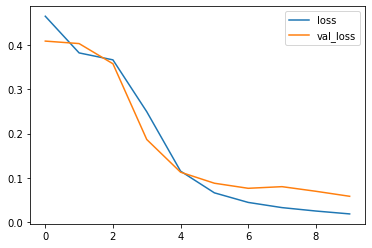

In [19]:
# 迭代損失函數
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

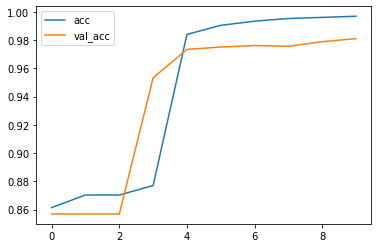

In [20]:
# 迭代準確度
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()